In [ ]:
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import os
from google.colab.patches import cv2_imshow
from skimage.feature import graycomatrix, graycoprops
from skimage.filters.rank import entropy
from skimage.morphology import disk
from skimage.filters import threshold_minimum, threshold_otsu
from skimage.exposure import equalize_hist

In [ ]:
model = tf.keras.models.load_model('best_model_glcm_dl.keras')
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ cnn_input (InputLayer)    │ (None, 64, 64, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 64, 64, 3)      │              0 │ cnn_input[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 64, 64, 3)      │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 64, 64, 3)      │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 65, 65, 3)      │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 32, 32, 40)     │          1,080 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 32, 32, 40)     │            160 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 32, 32, 40)     │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 32, 32, 40)     │            360 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 32, 32, 40)     │            160 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 32, 32, 40)     │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 40)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 40)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 10)       │            410 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 32,777,360 (125.04 MB)

 Trainable params: 10,896,685 (41.57 MB)

 Non-trainable params: 87,303 (341.03 KB)

 Optimizer params: 21,793,372 (83.14 MB)

In [ ]:
def extract_glcm_features(image, distances=[1], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4], levels=64):
    """
    Extract GLCM features from a grayscale image.
    """
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = (image / 256 * levels).astype(np.uint8)
    glcm = graycomatrix(image, distances=distances, angles=angles, levels=levels, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast').flatten()
    dissimilarity = graycoprops(glcm, 'dissimilarity').flatten()
    homogeneity = graycoprops(glcm, 'homogeneity').flatten()
    energy = graycoprops(glcm, 'energy').flatten()
    correlation = graycoprops(glcm, 'correlation').flatten()
    asm = graycoprops(glcm, 'ASM').flatten()
    features = np.hstack([contrast, dissimilarity, homogeneity, energy, correlation, asm])
    return features

def enhance_contrast(image):
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    enhanced = equalize_hist(image)
    return (enhanced * 255).astype(np.uint8)

def apply_entropy_filter(image, disk_size=5):
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = image.astype(np.uint8)
    return entropy(image, disk(disk_size))

def apply_minimum_error_thresholding(image):
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    try:
        thresh_val = threshold_minimum(image)
    except RuntimeError:
        thresh_val = threshold_otsu(image)
    thresholded = (image > thresh_val).astype(np.uint8) * 255
    return thresholded

In [ ]:
# List your image paths here
image_paths = [
    '/content/good1.png',
    '/content/good2.png',
    '/content/good3.png',
    '/content/hole1.png',
    '/content/hole2.png',
    '/content/hole3.png',
    '/content/hole4.png',
    '/content/obj1.png',
    '/content/obj2.png',
    '/content/obj3.png',
    '/content/obj4.png',
    '/content/oil1.png',
    '/content/oil2.png',
    '/content/oil3.png',
    '/content/oil4.png',
    '/content/thread1.png',
    '/content/thread2.png',
    '/content/thread3.png',
    '/content/thread4.png'
]

In [ ]:
def make_gradcam_heatmap(img_array, glcm_feature, model, last_conv_layer_name, pred_index=None):
    """
    Creates a Grad-CAM heatmap for a given image and its corresponding GLCM feature.
    """
    grad_model = tf.keras.models.Model(
        inputs=model.inputs,
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model({"cnn_input": img_array, "glcm_input": glcm_feature})
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        target_class_channel = predictions[:, pred_index]

    grads = tape.gradient(target_class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # ReLU and normalize the heatmap
    heatmap = tf.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + tf.keras.backend.epsilon())
    return heatmap.numpy()

def display_gradcam_details(original_img, heatmap, alpha=0.4, title=None):
    """
    Displays three images side-by-side:
      1. Original image
      2. Grad-CAM heatmap (colored)
      3. Overlay of the heatmap on the original image

    Parameters:
        original_img (numpy array): Original image (BGR format) as loaded by cv2.
        heatmap (numpy array): Grad-CAM heatmap (normalized between 0 and 1).
        alpha (float): Transparency factor for overlay.
        title (str): Optional title for the entire figure.
    """
    # Resize heatmap to match original image size
    heatmap_resized = cv2.resize(heatmap, (original_img.shape[1], original_img.shape[0]))
    heatmap_uint8 = np.uint8(255 * heatmap_resized)
    heatmap_colored = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET)

    # Create overlay
    overlay = cv2.addWeighted(original_img, 1 - alpha, heatmap_colored, alpha, 0)

    # Convert BGR to RGB for matplotlib
    original_rgb = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
    heatmap_rgb = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)
    overlay_rgb = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)

    # Plot the images side-by-side
    plt.figure(figsize=(15,5))
    plt.subplot(1, 3, 1)
    plt.imshow(original_rgb)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(heatmap_rgb)
    plt.title('Grad-CAM Heatmap')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(overlay_rgb)
    plt.title('Overlay')
    plt.axis('off')

    if title:
        plt.suptitle(title, fontsize=16)

    plt.show()
    plt.close()

In [ ]:
# layer to use for Grad-CAM
last_conv_layer_name = "top_conv"

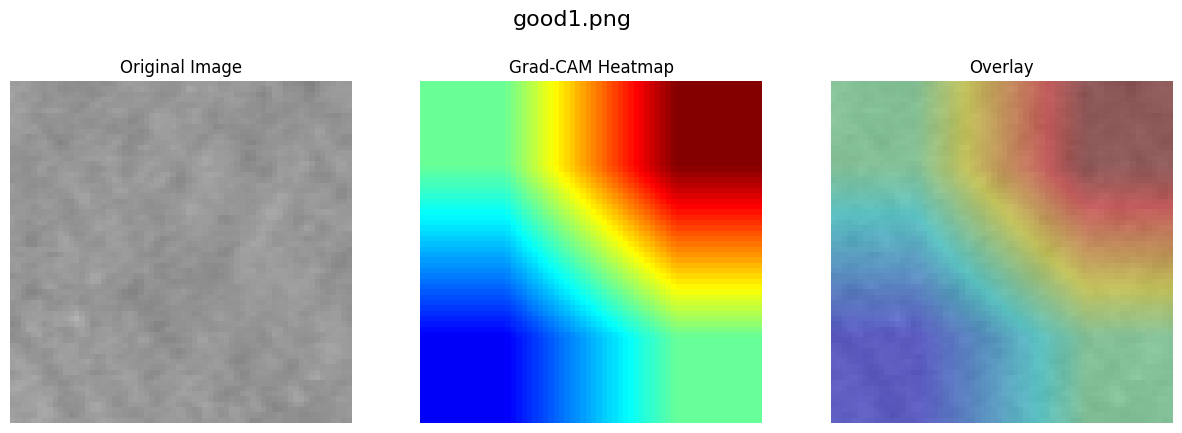

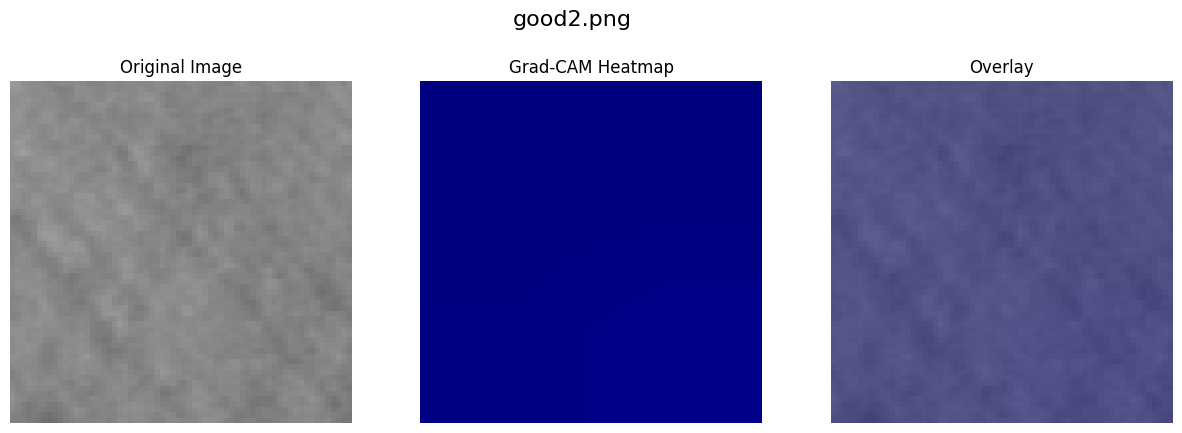

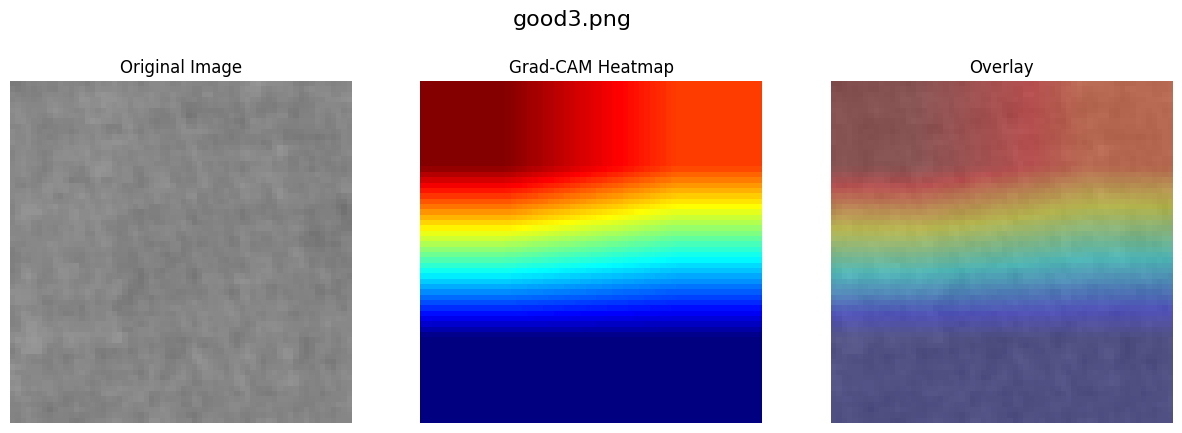

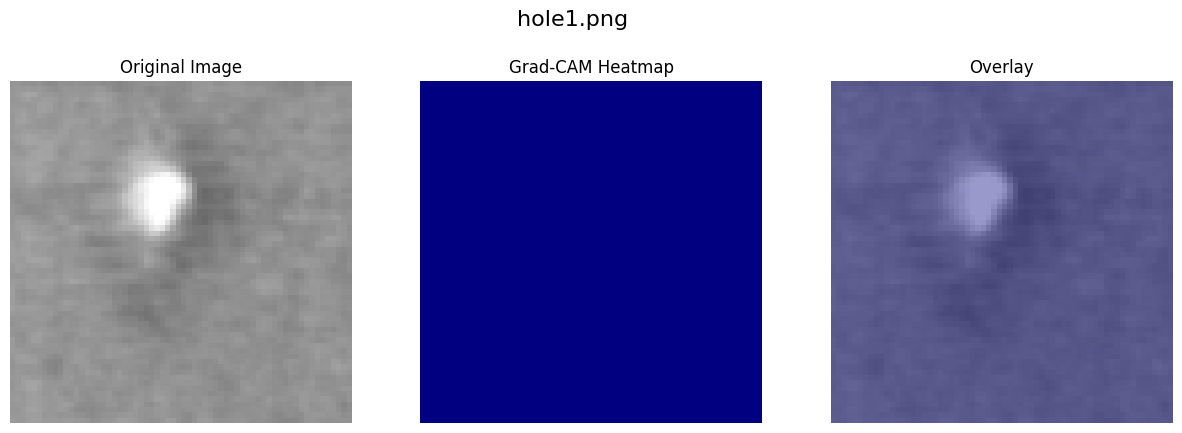

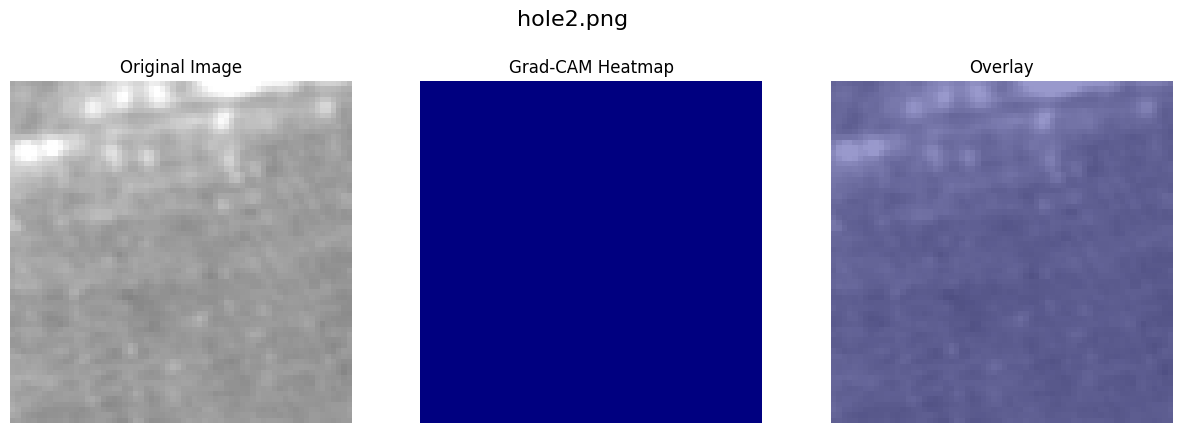

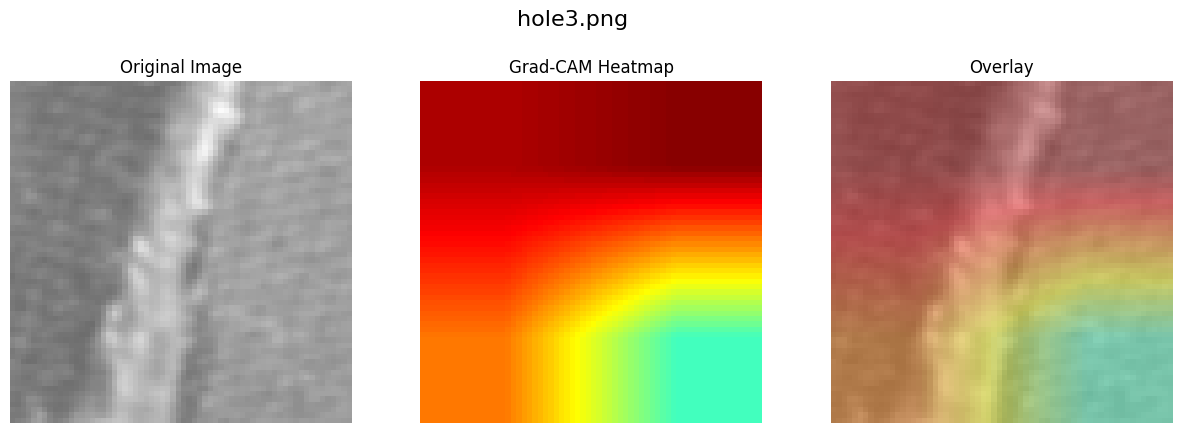

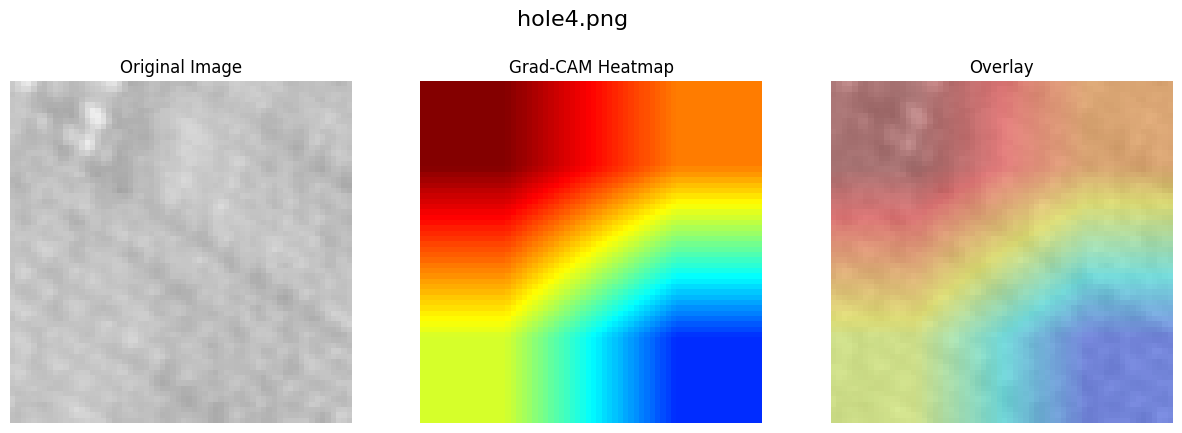

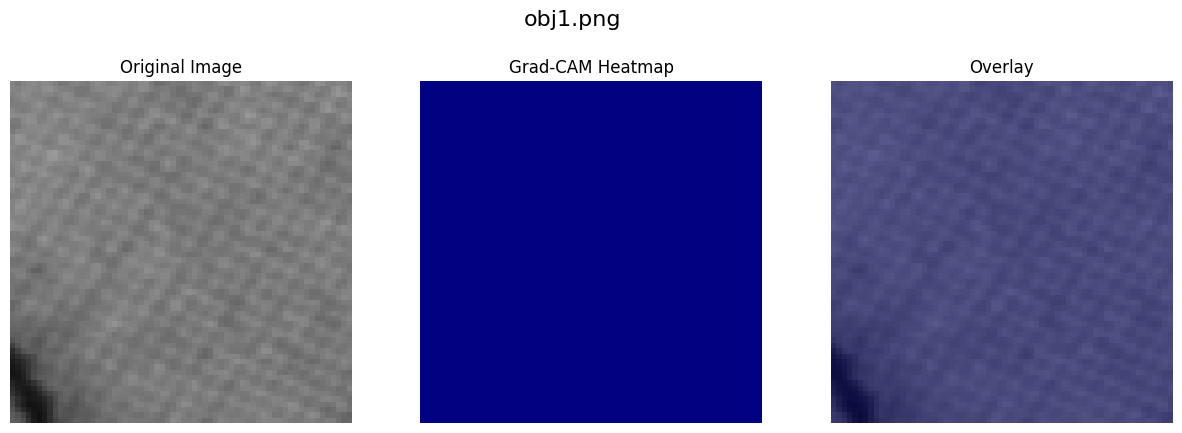

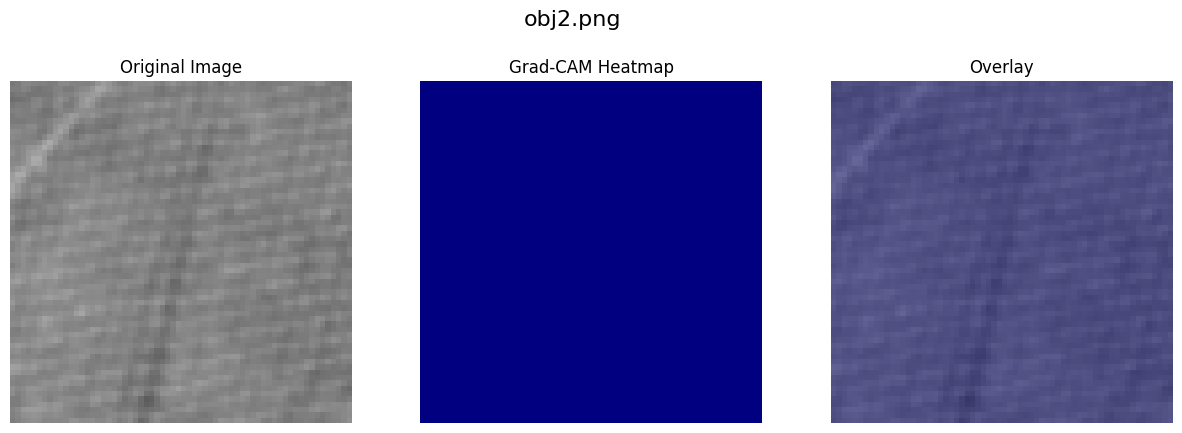

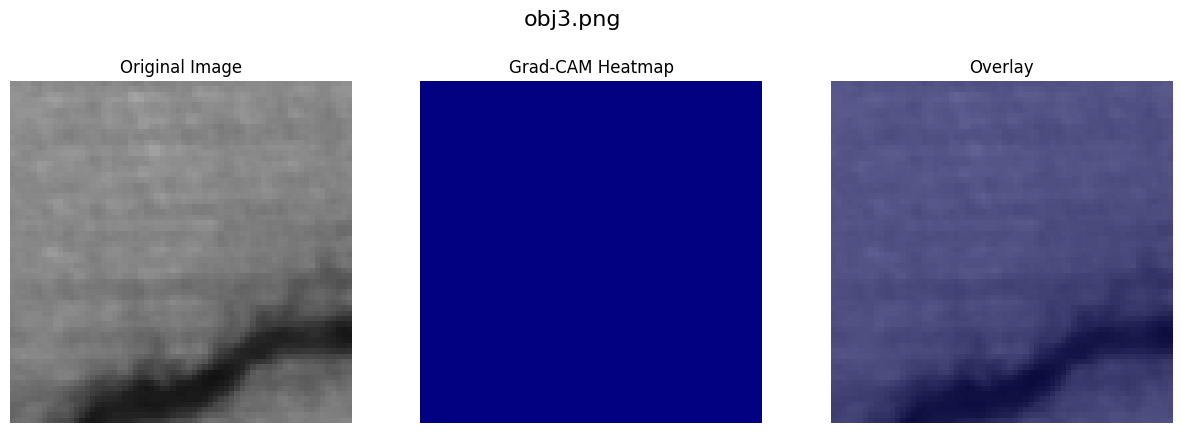

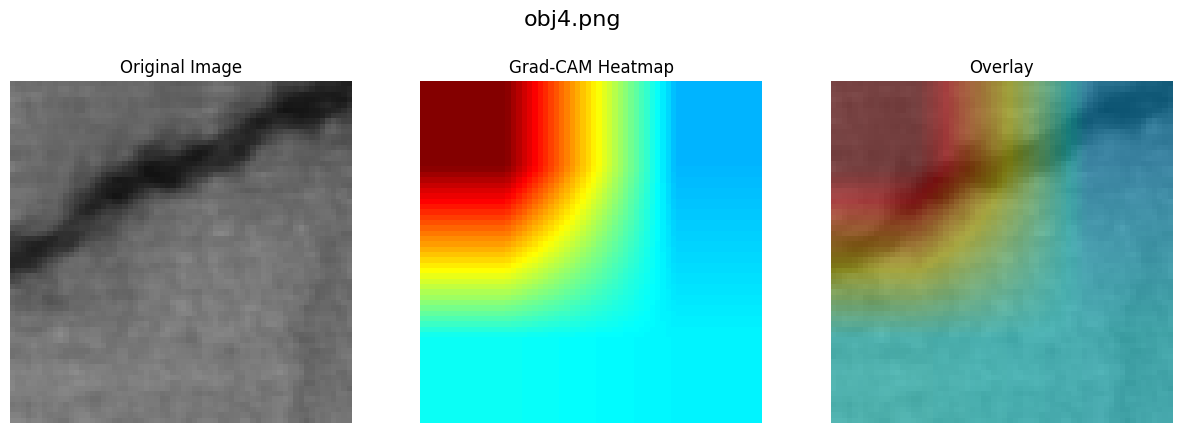

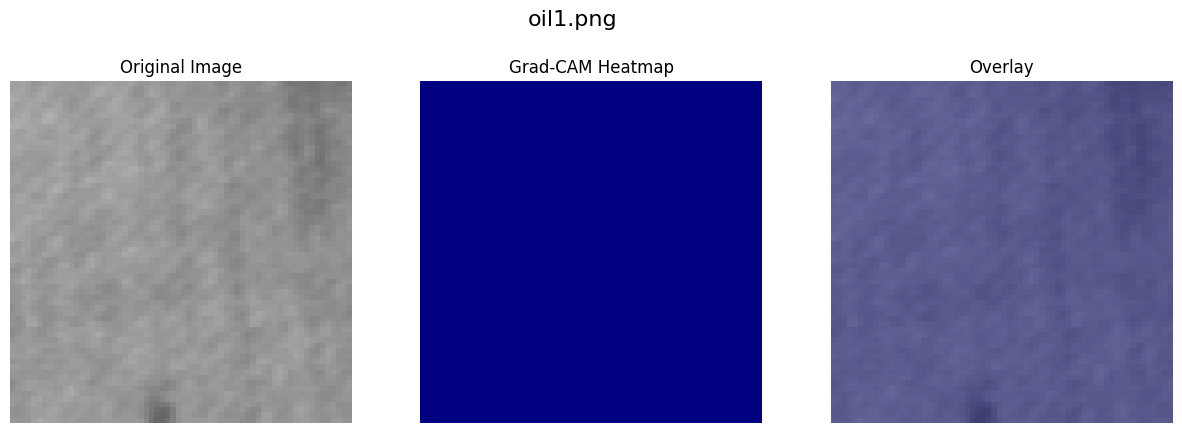

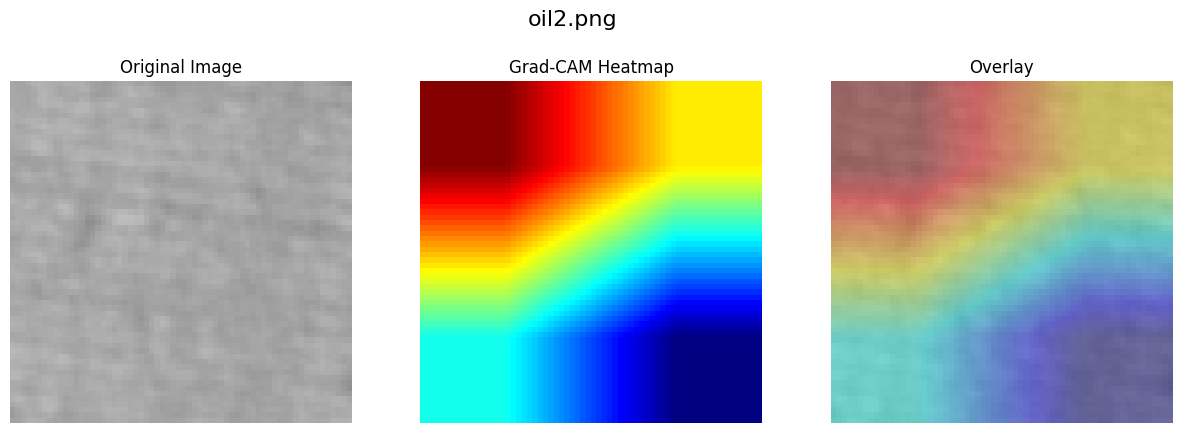

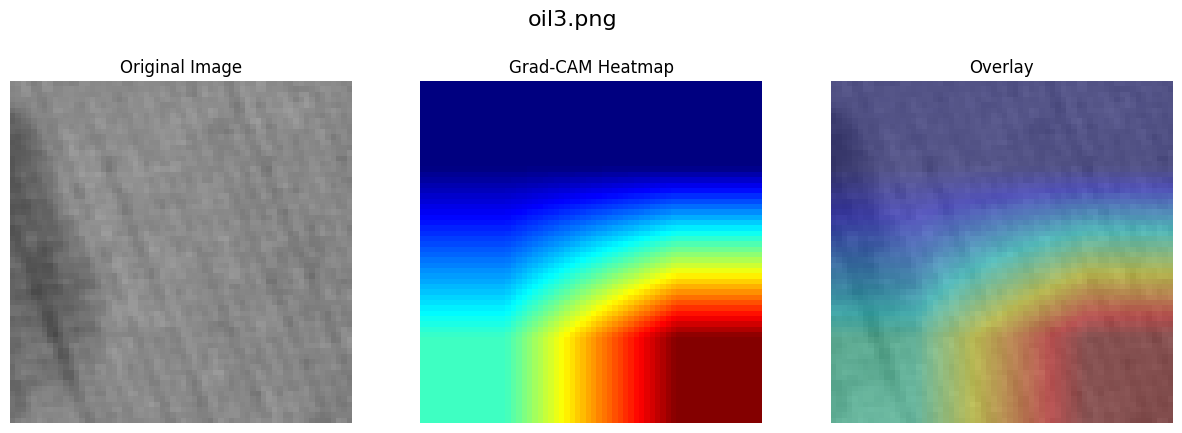

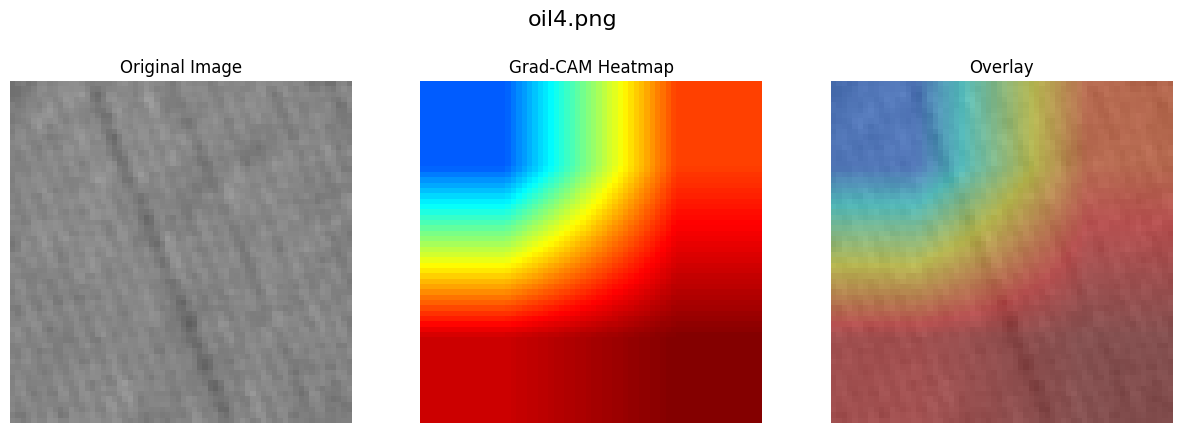

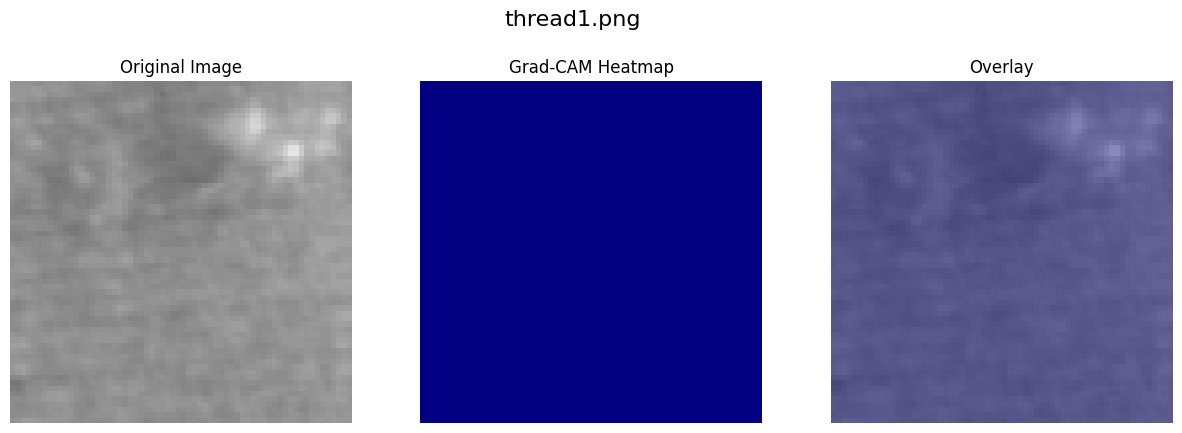

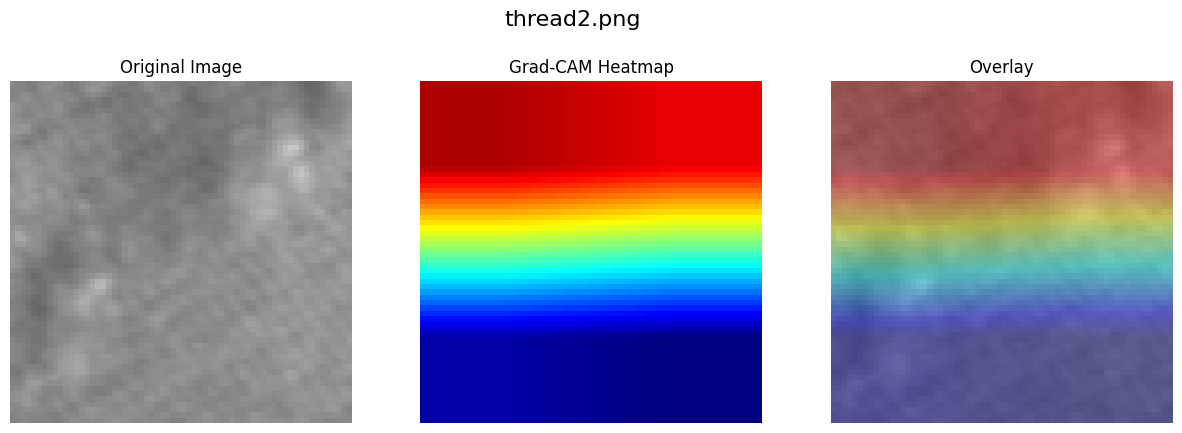

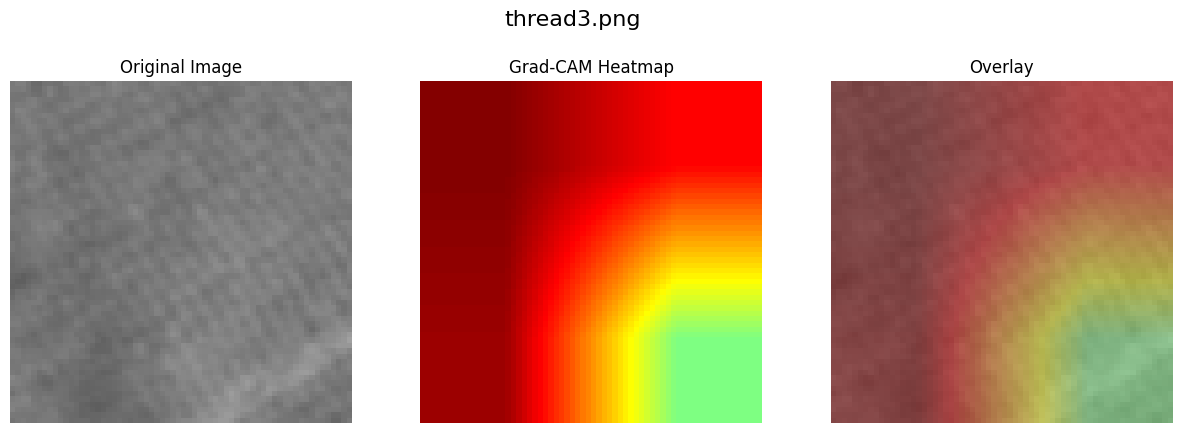

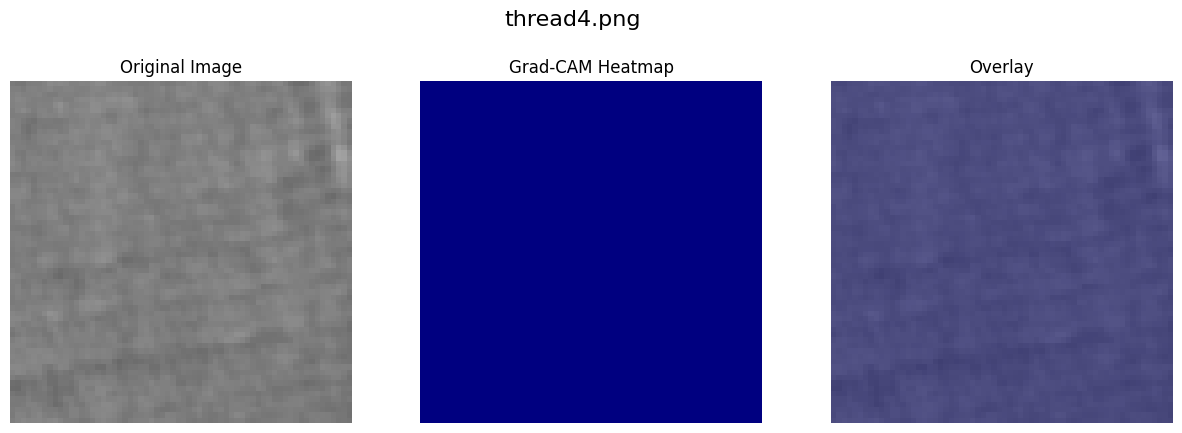

In [ ]:
for img_path in image_paths:
    original_img = cv2.imread(img_path)
    if original_img is None:
        print(f"Image not found at {img_path}")
        continue
    original_img = cv2.resize(original_img, (64, 64))

    img_input = np.expand_dims(original_img, axis=0)

    # For the GLCM branch, run the same preprocessing pipeline as in training:
    entropy_img = apply_entropy_filter(original_img)
    enhanced_img = enhance_contrast(entropy_img)
    thresholded_img = apply_minimum_error_thresholding(enhanced_img)
    glcm_features = extract_glcm_features(thresholded_img)
    glcm_features = np.expand_dims(glcm_features, axis=0)      # shape: (1, 24)

    # Generate Grad-CAM heatmap
    heatmap = make_gradcam_heatmap(img_input, glcm_features, model, last_conv_layer_name)

    display_gradcam_details(original_img, heatmap, alpha=0.4, title=os.path.basename(img_path))
